<a href="https://colab.research.google.com/github/VasundharaSK/News-Sentiment-Analysis/blob/main/Newsentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack, csr_matrix
from textblob import TextBlob
import nltk
import re
import datetime
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVR
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from wordcloud import WordCloud, STOPWORDS 
%matplotlib inline


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_file.csv to test_file.csv
Saving train_file.csv to train_file.csv


In [ ]:
import io
train = pd.read_csv(io.BytesIO(uploaded['train_file.csv']))
test = pd.read_csv(io.BytesIO(uploaded['test_file.csv']))


In [ ]:
train.head()


,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,-1,-1,-1,0.000000,-0.053300
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,-1,-1,-1,0.208333,-0.156386
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-1,-1,-1,-0.425210,0.139754
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,-1,-1,-1,0.000000,0.026064
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,-1,-1,-1,0.000000,0.141084


In [ ]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55932 entries, 0 to 55931
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             55932 non-null  object 
 1   Title              55932 non-null  object 
 2   Headline           55932 non-null  object 
 3   Source             55757 non-null  object 
 4   Topic              55932 non-null  object 
 5   PublishDate        55932 non-null  object 
 6   Facebook           55932 non-null  int64  
 7   GooglePlus         55932 non-null  int64  
 8   LinkedIn           55932 non-null  int64  
 9   SentimentTitle     55932 non-null  float64
 10  SentimentHeadline  55932 non-null  float64
dtypes: float64(2), int64(3), object(6)
memory usage: 4.7+ MB


In [ ]:
train.describe()

,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
count,55932.000000,55932.000000,55932.000000,55932.000000,55932.000000
mean,132.050329,4.551616,14.300132,-0.006318,-0.029577
std,722.931314,21.137177,76.651420,0.137569,0.143038
min,-1.000000,-1.000000,-1.000000,-0.838525,-0.755355
25%,0.000000,0.000000,0.000000,-0.079057,-0.116927
50%,6.000000,0.000000,0.000000,0.000000,-0.027277
75%,37.000000,2.000000,4.000000,0.063969,0.057354
max,49211.000000,1267.000000,3716.000000,0.962354,0.964646


In [ ]:
train.isnull().sum()

IDLink                 0
Title                  0
Headline               0
Source               175
Topic                  0
PublishDate            0
Facebook               0
GooglePlus             0
LinkedIn               0
SentimentTitle         0
SentimentHeadline      0
dtype: int64

In [ ]:
test.isnull().sum()


IDLink           0
Title            0
Headline         0
Source         101
Topic            0
PublishDate      0
Facebook         0
GooglePlus       0
LinkedIn         0
dtype: int64

In [ ]:
train['Source'].value_counts()[:10]

Bloomberg           992
Reuters             763
ABC News            645
New York Times      573
The Guardian        551
Business Insider    550
Forbes              484
Economic Times      461
CNN                 447
WinBeta             445
Name: Source, dtype: int64

In [ ]:
#missing value imputation, u can try different ways, just to simplify the approach we are imputing missing value with highest value available in that columns
train['Source'] = train['Source'].fillna('Bloomberg')
test['Source'] = test['Source'].fillna('Bloomberg')


In [ ]:
#Text column processing and cleaning
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

def clean(text):
  text_token = word_tokenize(text)
  filtered_text = ' '.join([w.lower() for w in text_token if w.lower() not in stop and len(w) > 2])
  filtered_text = filtered_text.replace(r"[^a-zA-Z]+", '')
  text_only = re.sub(r'\b\d+\b', '', filtered_text)
  clean_text = text_only.replace(',', '').replace('.', '').replace(':', '')
  return clean_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#combining the columns so that we can clean and start training the model
train['Text_Title'] = train['Title'] + ' ' + train['Source'] + ' ' + train['Topic']
test['Text_Title'] = test['Title'] + ' ' + test['Source'] + ' ' + test['Topic']

train['Text_Headline'] = train['Headline'] + ' ' + train['Source'] + ' ' + train['Topic']
test['Text_Headline'] = test['Headline'] + ' ' + test['Source'] + ' ' + test['Topic']

In [ ]:
train['Text_Title'][10]

'Microsoft Project Centennial seen with “universal” desktop Office SlashGear microsoft'

In [ ]:
#clean the combined text
train['Text_Title'] = [clean(x) for x in train['Text_Title']]
test['Text_Title'] = [clean(x) for x in test['Text_Title']]
train['Text_Headline'] = [clean(x) for x in train['Text_Headline']]
test['Text_Headline'] = [clean(x) for x in test['Text_Headline']]


In [ ]:
train['Text_Title'][10]

'microsoft project centennial seen universal desktop office slashgear microsoft'

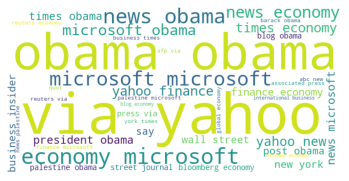

In [ ]:
#Word Cloud is a data visualization technique used for representing text data in which the size of each word 
#indicates its frequency or importance
#word cloud for text title
text = ""
for ind, row in train.iterrows():
    text += row["Text_Title"] + " "
text = text.strip()

wordcloud = WordCloud(background_color='white', width=600, height=300, max_font_size=100, max_words=40).generate(text)
wordcloud.recolor(random_state=ind*312)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

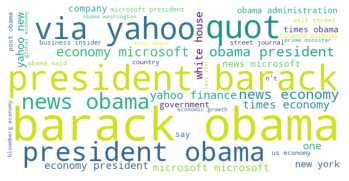

In [ ]:
#word cloud for text headline

text = ""
for ind, row in train.iterrows():
    text += row["Text_Headline"] + " "
text = text.strip()

wordcloud = WordCloud(background_color='white', width=600, height=300, max_font_size=100, max_words=40).generate(text)
wordcloud.recolor(random_state=ind*312)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()



In [ ]:
#Feature extraction from text
vectorizer = TfidfVectorizer(use_idf=True)

train_v_Title = vectorizer.fit_transform(train['Text_Title'])
test_v_Title = vectorizer.transform(test['Text_Title'])

vectorizer_ = TfidfVectorizer()

train_v_Headline = vectorizer_.fit_transform(train['Text_Headline'])
test_v_Headline = vectorizer_.transform(test['Text_Headline'])

Calculate sentiment of text using texblolb

In [ ]:
#sentiment for title text
train['polarity_t'] = train['Title'].apply(lambda x: TextBlob(x).sentiment.polarity)
test['polarity_t'] = test['Title'].apply(lambda x: TextBlob(x).sentiment.polarity)

train['subjectivity_t'] = train['Title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
test['subjectivity_t'] = test['Title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [ ]:
train.head(5)

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline,Text_Title,Text_Headline,polarity_t,subjectivity_t
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,-1,-1,-1,0.000000,-0.053300,obama lays wreath arlington national cemetery ...,obama lays wreath arlington national cemetery ...,0.0,0.0
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,-1,-1,-1,0.208333,-0.156386,look health chinese economy bloomberg economy,tim haywood investment director business-unit ...,0.0,0.0
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-1,-1,-1,-0.425210,0.139754,nouriel roubini global economy back bloomberg...,nouriel roubini nyu professor chairman roubini...,0.0,0.0
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,-1,-1,-1,0.000000,0.026064,finland gdp expands rtt news economy,finland economy expanded marginally three mont...,0.0,0.0
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,-1,-1,-1,0.000000,0.141084,tourism govt spending buoys thai economy janua...,tourism public spending continued boost econom...,0.0,0.0


In [ ]:
#sentiment for headline text
train['polarity_h'] = train['Headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
test['polarity_h'] = test['Headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

train['subjectivity_h'] = train['Headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
test['subjectivity_h'] = test['Headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [ ]:
train.head(5)

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline,Text_Title,Text_Headline,polarity_t,subjectivity_t,polarity_h,subjectivity_h
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,-1,-1,-1,0.000000,-0.053300,obama lays wreath arlington national cemetery ...,obama lays wreath arlington national cemetery ...,0.0,0.0,0.000000,0.000000
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,-1,-1,-1,0.208333,-0.156386,look health chinese economy bloomberg economy,tim haywood investment director business-unit ...,0.0,0.0,0.100000,0.200000
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-1,-1,-1,-0.425210,0.139754,nouriel roubini global economy back bloomberg...,nouriel roubini nyu professor chairman roubini...,0.0,0.0,0.000000,0.041667
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,-1,-1,-1,0.000000,0.026064,finland gdp expands rtt news economy,finland economy expanded marginally three mont...,0.0,0.0,-0.166667,0.166667
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,-1,-1,-1,0.000000,0.141084,tourism govt spending buoys thai economy janua...,tourism public spending continued boost econom...,0.0,0.0,0.133333,0.380556


In [ ]:
#Encode categorical columns
encoder = LabelEncoder()

train['Topic'] = encoder.fit_transform(train['Topic'])
test['Topic'] = encoder.transform(test['Topic'])

total = train['Source'].to_list() + test['Source'].to_list()
total = encoder.fit_transform(total)
train['Source'] = encoder.transform(train['Source'])
test['Source'] = encoder.transform(test['Source'])


In [ ]:
#Meta Features
# Get day-type(monday, tuesday) from datetime


train_weekday = []
test_weekday = []

for i in train['PublishDate']:
    train_weekday.append(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").strftime("%A"))
    
for i in test['PublishDate']:
    test_weekday.append(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").strftime("%A"))

train['weekday'] = train_weekday
test['weekday'] = test_weekday


# convert weekday to 0-6

train['weekday'] = train['weekday'].map({'Monday': 0,
                                        'Tuesday': 1,
                                        'Wednesday': 2,
                                        'Thursday': 3,
                                        'Friday': 4,
                                        'Saturday': 5,
                                        'Sunday': 6})
test['weekday'] = test['weekday'].map({'Monday': 0,
                                        'Tuesday': 1,
                                        'Wednesday': 2,
                                        'Thursday': 3,
                                        'Friday': 4,
                                        'Saturday': 5,
                                        'Sunday': 6})

In [ ]:
# Hour from date

train["hour"] = train["PublishDate"].apply(lambda x: x.split()[1].split(':')[0])
test["hour"] = test["PublishDate"].apply(lambda x: x.split()[1].split(':')[0])

Text(0, 0.5, 'SentimentTitle')

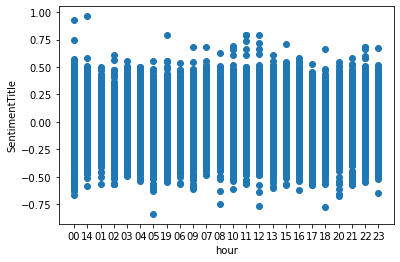

In [ ]:
# hour distribution of SentimentTitle

plt.scatter(train['hour'], train['SentimentTitle'])
plt.xlabel('hour')
plt.ylabel('SentimentTitle')

Text(0, 0.5, 'SentimentHeadline')

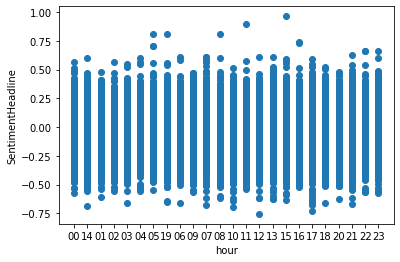

In [ ]:
# hour distribution of SentimentHeadline
import matplotlib.pyplot as plt

plt.scatter(train['hour'], train['SentimentHeadline'])
plt.xlabel('hour')
plt.ylabel('SentimentHeadline')

Text(0, 0.5, 'SentimentTitle')

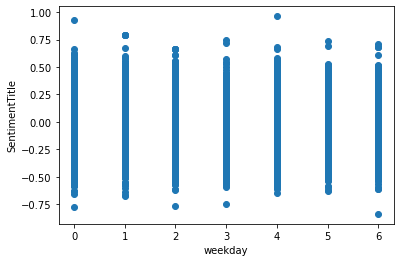

In [ ]:
# weekday distribution of SentimentTitle

plt.scatter(train['weekday'], train['SentimentTitle'])
plt.xlabel('weekday')
plt.ylabel('SentimentTitle')

In [ ]:
# Number of words in the Title 
train["num_words_t"] = train["Text_Title"].apply(lambda x: len(str(x).split()))
test["num_words_t"] = test["Text_Title"].apply(lambda x: len(str(x).split()))

# Number of unique words in the Title 
train["num_unique_words_t"] = train["Text_Title"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words_t"] = test["Text_Title"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the Title 
train["num_chars_t"] = train["Text_Title"].apply(lambda x: len(str(x)))
test["num_chars_t"] = test["Text_Title"].apply(lambda x: len(str(x)))

# Average length of the words in the Title 
train["mean_word_len_t"] = train["Text_Title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len_t"] = test["Text_Title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
# Number of words in the Headline 
train["num_words_h"] = train["Text_Headline"].apply(lambda x: len(str(x).split()))
test["num_words_h"] = test["Text_Headline"].apply(lambda x: len(str(x).split()))

# Number of unique words in the Headline 
train["num_unique_words_h"] = train["Text_Headline"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words_h"] = test["Text_Headline"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the Headline 
train["num_chars_h"] = train["Text_Headline"].apply(lambda x: len(str(x)))
test["num_chars_h"] = test["Text_Headline"].apply(lambda x: len(str(x)))

# Average length of the words in the Headline 
train["mean_word_len_h"] = train["Text_Headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len_h"] = test["Text_Headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [39]:
#standardization
scaler = StandardScaler()

cols = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_t', 'num_unique_words_t', 'num_chars_t', 'mean_word_len_t',
        'num_words_h', 'num_unique_words_h', 'num_chars_h', 'mean_word_len_h', 'hour', 'weekday']

for col in cols:
  train[col] = scaler.fit_transform(train[col].values.reshape(-1, 1))
  test[col] = scaler.transform(test[col].values.reshape(-1, 1))

In [41]:
cols_t = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_t', 'num_unique_words_t', 'num_chars_t', 'mean_word_len_t', 'polarity_t', 'subjectivity_t', 'hour', 'weekday']
train_X1 = train[cols_t]
test_X1 = test[cols_t]

cols_h = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_h', 'num_unique_words_h', 'num_chars_h', 'mean_word_len_h', 'polarity_h', 'subjectivity_h', 'hour', 'weekday']
train_X2 = train[cols_h]
test_X2 = test[cols_h]

In [42]:
train_X1.head()


,Source,Topic,Facebook,GooglePlus,LinkedIn,num_words_t,num_unique_words_t,num_chars_t,mean_word_len_t,polarity_t,subjectivity_t,hour,weekday
0,1.257700,0.841443,-0.184044,-0.262649,-0.199608,-0.25916,-0.304674,-0.572741,-0.612986,0.0,0.0,-1.699073,-0.795924
1,-1.314091,-1.108773,-0.184044,-0.262649,-0.199608,-1.66871,-1.721687,-1.629606,0.274360,0.0,0.0,-1.699073,1.338369
2,-1.314091,-1.108773,-0.184044,-0.262649,-0.199608,-1.19886,-1.249349,-1.035120,0.328687,0.0,0.0,-1.699073,1.338369
3,0.468412,-1.108773,-0.184044,-0.262649,-0.199608,-1.66871,-1.249349,-2.224092,-1.436950,0.0,0.0,-1.699073,1.871942
4,1.029071,-1.108773,-0.184044,-0.262649,-0.199608,1.15039,1.112340,1.012556,-0.296077,0.0,0.0,-1.699073,1.871942


In [43]:
train_X2.head()


,Source,Topic,Facebook,GooglePlus,LinkedIn,num_words_h,num_unique_words_h,num_chars_h,mean_word_len_h,polarity_h,subjectivity_h,hour,weekday
0,1.257700,0.841443,-0.184044,-0.262649,-0.199608,-0.285960,-0.526779,-0.490565,-1.058634,0.000000,0.000000,-1.699073,-0.795924
1,-1.314091,-1.108773,-0.184044,-0.262649,-0.199608,-0.285960,-0.232528,-0.317704,-0.175984,0.100000,0.200000,-1.699073,1.338369
2,-1.314091,-1.108773,-0.184044,-0.262649,-0.199608,-0.413322,-0.673904,-0.300418,0.618402,0.000000,0.041667,-1.699073,1.338369
3,0.468412,-1.108773,-0.184044,-0.262649,-0.199608,0.096128,0.061723,0.304596,0.843478,-0.166667,0.166667,-1.699073,1.871942
4,1.029071,-1.108773,-0.184044,-0.262649,-0.199608,0.223490,0.208849,0.391026,0.618402,0.133333,0.380556,-1.699073,1.871942


In [44]:
print(np.shape(train_X1))
print(np.shape(test_X1))

(55932, 13)
(37288, 13)


In [45]:
print(np.shape(train_X2))
print(np.shape(test_X2))

(55932, 13)
(37288, 13)


In [46]:
print(np.shape(train_v_Title))
print(np.shape(test_v_Title))

(55932, 25377)
(37288, 25377)


In [47]:

print(np.shape(train_v_Headline))
print(np.shape(test_v_Headline))

(55932, 38787)
(37288, 38787)


In [55]:
train_X_Title = hstack([train_v_Title, csr_matrix(train_X1.values)])
test_X_Title = hstack([test_v_Title, csr_matrix(test_X1.values)])
y1 = train['SentimentTitle']
print(train_X_Title)

  (0, 22863)	0.22680431765059245
  (0, 23880)	0.2610620394317479
  (0, 3787)	0.43479787342971216
  (0, 15035)	0.2541867327718132
  (0, 1499)	0.48190509275921933
  (0, 25036)	0.48190509275921933
  (0, 12839)	0.3567944716172106
  (0, 15613)	0.18702672369324277
  (1, 2709)	0.37289055902776347
  (1, 7132)	0.320031564096322
  (1, 4061)	0.46609262810950425
  (1, 10201)	0.5119178713761268
  (1, 13321)	0.5284223537642353
  (2, 1950)	0.3349546931893074
  (2, 9478)	0.27030727379205394
  (2, 19354)	0.5822054678108656
  (2, 15507)	0.592673617053479
  (2, 2709)	0.2677695953257499
  (2, 7132)	0.22981199264730795
  (3, 15225)	0.17735429852858942
  (3, 19407)	0.5419634897624132
  (3, 7946)	0.41835967370710336
  (3, 9279)	0.39595341461145556
  (3, 8527)	0.5725498875993331
  (3, 7132)	0.12330341293404921
  :	:
  (55929, 25388)	-1.5553969654148536
  (55929, 25389)	-0.7959239487209264
  (55930, 25377)	0.7923992191163056
  (55930, 25378)	-0.13366506190091457
  (55930, 25379)	-0.18266121113151085
  (55930, 

In [57]:
train_X_Headline = hstack([train_v_Headline, csr_matrix(train_X2.values)])
test_X_Headline = hstack([test_v_Headline, csr_matrix(test_X2.values)])
y2 = train['SentimentHeadline']

In [58]:
np.shape(train_X_Title)


(55932, 25390)

Apply Machine Learning **Models**

In [59]:

# LinearSVR model for SentimentTitle

X_train, X_test, y_train, y_test = train_test_split(train_X_Title, y1, test_size=0.20, random_state=42)

clf1 = LinearSVR(C=0.2)
clf1.fit(X_train, y_train)

y_pred1 = clf1.predict(X_test)
mae1 = mean_absolute_error(y_pred1, y_test)
print('MAE:', 1 - mae1)

MAE: 0.9433255891230866


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [60]:
# LinearSVR model for SentimentHeadline

X_train, X_test, y_train, y_test = train_test_split(train_X_Headline, y2, test_size=0.20, random_state=42)

clf2 = LinearSVR(C=0.1)
clf2.fit(X_train, y_train)

y_pred2 = clf2.predict(X_test)
mae2 = mean_absolute_error(y_pred2, y_test)
print('MAE:', 1 - mae2)

MAE: 0.9291560321119218


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [61]:
print('MAE:', 1 - ((0.4 * mae1) + (0.6 * mae2)))


MAE: 0.9348238549163878


In [62]:
#Make predictions for test dataset
title = clf1.predict(test_X_Title)
headline = clf2.predict(test_X_Headline)

In [66]:

df = pd.DataFrame()
test_id = test['IDLink']

df['IDLink'] = test_id
df['SentimentTitle'] = title
df['SentimentHeadline'] = headline
df.to_csv(r"C:\Users\VK\MLPython\Extras\News\dataset\sample_submission.csv", index=False)